# Exploration & Cleaning For Project 1 - John Commander, Wusi Fan, Bill Magill & Abdul Hussain

For our project, we were interested in exploring the relationship between MLS attendance and several key factors, mainly focused on several demographic categories, namely age, ethnicity and income level, with team performance as another main factor in our research.

We obtained MLS attendance data from online in the form of excel spreadsheets which contained attendance data for the years 2012 to 2017. We also obtained team performance from online and put it into excel sheets and CSVs so that they could be accessed for this project.

Our demographic data was obtained using the U.S. Census API, an API maintained by the US Government that allows citizens to make use of the incredibly extensive data in the US Census. Below is the process by which we called the API, organized it into Pandas dataframes, imported the excel sheets and CSVs into dataframes, and then cleaned the data set up.

In [26]:
# Import Dependencies

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
from config import api_key
import seaborn as sns
import statsmodels.api as sm

# US Census API

Below this is the code we used to call the US Census API database for information. Unlike other APIs we've been using in this class, the Census API doesn't allow for queries or keywords to be used to find information. Instead, when constructing the query url, one has to specify a list of codes which return specific values with them. The cell below lists the particular codes. For example, if one calls code B01001_007E, one would return a singular numeric value which would be the total count of Males Ages 19 to 19 in the Geographic location one specified. Thus, to get a count of all persons between the ages of 18 to 44, we had to call each one of the listed codes for age.

Geographic location doesn't use keywords either, requiring the user to input a specific code for both city and state, which we found by examining the Census API's documentation (Which is in need of an update, it was very scattered and disorganized). We constructed a list of all necessary codes, which can be found below, before we arranged the call URLs.

In [2]:
#total_pop = "B01001_001E"

## Age Group Codes
#Males age 18 to 19 = B01001_007E
#Males age 20 = B01001_008E
#Males age 21 = B01001_009E
#Males age 22 to 24 = B01001_010E
#Males age 25 to 29 = B01001_011E
#Males age 30 to 34 = B01001_012E
#Males age 35 to 39 = B01001_013E
#Males age 40 to 44 = B01001_014E

#Females age 18 to 19 = B01001_031E
#Females age 20 = B01001_032E
#Females age 21 = B01001_033E
#Females age 22 to 24 = B01001_034E
#Females age 25 to 29 = B01001_035E
#Females age 30 to 34 = B01001_036E
#Females age 35 to 39 = B01001_037E
#Females age 40 to 44 = B01001_038E

## Ethnicity Group Codes
#White = B02001_002E
#Black = B02001_003E
#Latino = B03001_003E
#Native Indian = B02001_004E
#Asian = B02001_005E
#Pacific Islander = B02001_006E
#Other = B02001_007E

## NEW Income Level
#income_pop = B25121_001E
#Less than $10,000 = B25121_002E
#$10,000 to $19,999 = B25121_017E
#$20,000 to $34,999 = B25121_032E
#$35,000 to $49,999 = B25121_047E
#$50,000 to $74,999 = B25121_062E
#$75,000 to $99,999 = B25121_077E
#$100,000 or more = B25121_092E

## Income Level
#income_pop = B25095_001E
#Less than $10,000 = B25095_002E
#$10,000 to $19,999 = B25095_011E
#$20,000 to $34,999 = B25095_020E
#$35,000 to $49,999 = B25095_029E
#$50,000 to $74,999 = B25095_038E
#$75,000 to $99,999 = B25095_047E
#$100,000 to $149,999 = B25095_056E
#$150,000 or more = B25095_065E

## Education Level
#edu_pop = B23006_001E
#Less than high school graduate = B23006_002E
#High school graduate = B23006_009E
#Some college or associates = B23006_016E
#Bachelor's or higher = B23006_023E

In [3]:
# Build query URL for exploring Census API

# Base URL
url = "https://api.census.gov/data/2016/acs/acs5?get=NAME"

# API Key call, note this should always be at the end of the URL
key = "&key=" + api_key

# Call for states, note that the State's designated number should follow the colon
state = "&in=state:"

# Call for individual counties, note that you must make the county call with the state call, it cannot be called
# by itself. Also, the county number should follow the colon
county = "&for=county:"

# Places API Call, which allows for specific cities to be referred to. Requires the "state" call to be made as well,
# otherwise it might return an error.

city = "&for=place:"

# Metropolitan API call

metro = "&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:"

# ZIP code ZCTA API call

zip_code = "&for=zip%20code%20tabulation%20area:"

# Basic query url structure should look like this (Note that the "*" is used to call all values, so all states
# and cities within that state)
query_url = url + city + "04000" + state + "13" + key

# Json request
request = requests.get(query_url).json()

# Display result of request
request

[['NAME', 'state', 'place'], ['Atlanta city, Georgia', '13', '04000']]

Below are the URL snippets created to allow us to call certain values. The base url is found in every url and is simply the page location for the API. After that, one needs to input all of the value codes to return the values they desire. For example, the age_url contains a long list of codes which return the total number of males and females between the ages of 18 to 44, broken down by the Census' specific categories, which can be found in the table above where all the codes are listed.

We created four URLs to capture the values we desired for our data, between age, ethnicity, income and education.

In [4]:
# URLs with codes built in to make appropriate calls

# Base URL

base_url = "https://api.census.gov/data/"

# Age URL
age_url = "/acs/acs5?get=NAME,B01001_001E,B01001_007E,B01001_008E,B01001_009E,B01001_010E,"\
        +"B01001_011E,B01001_012E,B01001_013E,B01001_014E,B01001_031E,B01001_032E,B01001_033E,B01001_034E,B01001_035E,"\
        + "B01001_036E,B01001_037E,B01001_038E"

# Ethnicity URL
ethnicity_url = "/acs/acs5?get=NAME,B01001_001E,B02001_002E,B02001_003E,B03001_003E,B02001_005E"

# Income URL
income_url = "/acs/acs5?get=NAME,B25121_001E,B25121_002E,B25121_017E,B25121_032E,B25121_047E,B25121_062E,B25121_077E,"\
        +"B25121_092E"

# Education URL
edu_url = "/acs/acs5?get=NAME,B23006_001E,B23006_002E,B23006_009E,B23006_016E,B23006_023E"

# List of URLs for iteration in API

year_list = ["2012","2013","2014","2015","2016"]
url_list = [age_url,ethnicity_url,income_url,edu_url]

In [5]:
# Dictionary with state names as keys and the values being the corresponding code in the Census API
state_dict = {"Georgia":"13","Washington":"53","Florida":"12","New York":"36","California":"06","New Jersey":"34",\
               "Oregon":"41","Minnesota":"27","Kansas":"20","Massachusetts":"25","Utah":"49","Washington D.C.":"11",\
               "Texas":"48","Illinois":"17","Pennsylvania":"42","Ohio":"39","Colorado":"08"}

# Dictionary with city names as keys and the values being the corresponding code in the Census API
city_dict = {"Atlanta":"04000", "Seattle":"63000", "Orlando":"53000", "New York":"51000", "Carson":"11530",\
              "Harrison":"51000", "Portland":"59000", "Minneapolis":"43000", "San Jose":"68000", "Kansas City":"36000",\
              "Foxborough":"24855", "Sandy":"67440", "Washington D.C.":"50000", "Houston":"35000",\
              "Bridgeview":"08225", "Chester":"13208", "Columbus":"18000", "Commerce City":"16495", "Frisco":"27684"}

# List containing each state code in corresponding order for use in API call iteration
state_codes = ["13","53","12","36","06","34","41","27","06","20","25","49","11","48","17","42","39","08","48"]

# List containing each city code in corresponding order for use in API call iteration
city_codes = ["04000","63000","53000","51000","11530","51000","59000","43000","68000","36000","24855","67440","50000",\
             "35000","08225","13208","18000","16495","27684"]

Above is the list of cities, states and codes that we called to obtain our data. Each city corresponds to a team that plays in the MLS in the United States.

Below is the iteration where we actually perform the API call. Four lists were created to house the data. Once the API is called, it returns a list which contains the desired information, thus once we call the API, we append the returned list to the appropriate master list, thus creating a large list of lists for each variable between age, ethnicity, income and education.

We perform an API call for every year between 2012 to 2016, calling each url on each city, for a total of 380 calls. Each list contains 95 items, 5 items per city effectively, one for each year of data.

In [11]:
# API request iteration format (NOTE: running this cell takes time due to the time.sleep! Only run
# if you want the data itself! Running this will take at least 8 MINUTES before it finishes)

# Initialize lists to store data retrieved from the API

age_list = []
ethnicity_list = []
income_list = []
edu_list = []

counter = 1

for year in year_list:

    for num in range(19):
    
        for url in url_list:

            # Query URL construction that pulls from the city & state codes lists
            query_url = base_url + year + url + city + city_codes[num] + state + state_codes[num] + key
        
            try:
                request = requests.get(query_url).json()
        
                if url == age_url:
                    age_list.append(request[1])
                elif url == ethnicity_url:
                    ethnicity_list.append(request[1])
                elif url == income_url:
                    income_list.append(request[1])
                elif url == edu_url:
                    edu_list.append(request[1])
            
                time.sleep(1)
        
            except Exception:
                print(f"There was an error with this url: {query_url}")
    
        print(f"#{counter} for Year {year} has completed all calls")
    
        counter += 1
        
    counter = 1

#1 for Year 2012 has completed all calls
#2 for Year 2012 has completed all calls
#3 for Year 2012 has completed all calls
#4 for Year 2012 has completed all calls
#5 for Year 2012 has completed all calls
#6 for Year 2012 has completed all calls
#7 for Year 2012 has completed all calls
#8 for Year 2012 has completed all calls
#9 for Year 2012 has completed all calls
#10 for Year 2012 has completed all calls
#11 for Year 2012 has completed all calls
#12 for Year 2012 has completed all calls
#13 for Year 2012 has completed all calls
#14 for Year 2012 has completed all calls
#15 for Year 2012 has completed all calls
#16 for Year 2012 has completed all calls
#17 for Year 2012 has completed all calls
#18 for Year 2012 has completed all calls
#19 for Year 2012 has completed all calls
#1 for Year 2013 has completed all calls
#2 for Year 2013 has completed all calls
#3 for Year 2013 has completed all calls
#4 for Year 2013 has completed all calls
#5 for Year 2013 has completed all calls
#6 for

# Converting to Dataframes

Once we finished building the code for API queries and ran it, we began work on converting the raw data we'd retrieved into a readable, usable format. Below, we add the years to the lists and group the data into sets we desired. Using common MLS survey data as a guide, we elected to group the age category into two groups, 18 to 29 and 30 to 44. We also grouped income into three distinct categories: 34,000 dollars or less yearly income, 35,000 to 99,000 yearly and 100,000 or more yearly. For ethnicity, we focused on capturing values for White, African-American, Latino & Asian populations.

After this, we used Pandas to put all of these values into Dataframes, while also cleaning them up by giving the columns clear names and eliminating any extraneous columns which were created by using the API.

In [48]:
# Adding years to the age list

age_by_year = []

# For Loop

for num in range(95):
    
    if num <= 18:
        age_by_year.append(age_list[num])
        age_by_year[num].append("2012")
    elif num > 18 and num <= 37:
        age_by_year.append(age_list[num])
        age_by_year[num].append("2013")
    elif num > 37 and num <= 56:
        age_by_year.append(age_list[num])
        age_by_year[num].append("2014")
    elif num > 56 and num <= 75:
        age_by_year.append(age_list[num])
        age_by_year[num].append("2015")
    elif num > 75:
        age_by_year.append(age_list[num])
        age_by_year[num].append("2016")


In [49]:
# Adding years to the ethnicity list
ethnicity_by_year = []

# For Loop

for num in range(95):
    
    if num <= 18:
        ethnicity_by_year.append(ethnicity_list[num])
        ethnicity_by_year[num].append("2012")
    elif num > 18 and num <= 37:
        ethnicity_by_year.append(ethnicity_list[num])
        ethnicity_by_year[num].append("2013")
    elif num > 37 and num <= 56:
        ethnicity_by_year.append(ethnicity_list[num])
        ethnicity_by_year[num].append("2014")
    elif num > 56 and num <= 75:
        ethnicity_by_year.append(ethnicity_list[num])
        ethnicity_by_year[num].append("2015")
    elif num > 75:
        ethnicity_by_year.append(ethnicity_list[num])
        ethnicity_by_year[num].append("2016")


In [50]:
# Adding years to the income list
income_by_year = []

# For Loop

for num in range(95):
    
    if num <= 18:
        income_by_year.append(income_list[num])
        income_by_year[num].append("2012")
    elif num > 18 and num <= 37:
        income_by_year.append(income_list[num])
        income_by_year[num].append("2013")
    elif num > 37 and num <= 56:
        income_by_year.append(income_list[num])
        income_by_year[num].append("2014")
    elif num > 56 and num <= 75:
        income_by_year.append(income_list[num])
        income_by_year[num].append("2015")
    elif num > 75:
        income_by_year.append(income_list[num])
        income_by_year[num].append("2016")
        

In [51]:
# Adding years to the education list
edu_by_year = []

# For Loop

for num in range(95):
    
    if num <= 18:
        edu_by_year.append(edu_list[num])
        edu_by_year[num].append("2012")
    elif num > 18 and num <= 37:
        edu_by_year.append(edu_list[num])
        edu_by_year[num].append("2013")
    elif num > 37 and num <= 56:
        edu_by_year.append(edu_list[num])
        edu_by_year[num].append("2014")
    elif num > 56 and num <= 75:
        edu_by_year.append(edu_list[num])
        edu_by_year[num].append("2015")
    elif num > 75:
        edu_by_year.append(edu_list[num])
        edu_by_year[num].append("2016")


In [52]:
# Use iterative loop to convert valus into integers & sum the values in the age list,
# thus combining male and female data

age_combine = []

for num in range(95):
    
    city = age_by_year[num][0]
    pop = int(age_by_year[num][1])
    tot1819 = int(age_by_year[num][2]) + int(age_by_year[num][10])
    tot20 = int(age_by_year[num][3]) + int(age_by_year[num][11])
    tot21 = int(age_by_year[num][4]) + int(age_by_year[num][12])
    tot2224 = int(age_by_year[num][5]) + int(age_by_year[num][13])
    tot2529 = int(age_by_year[num][6]) + int(age_by_year[num][14])
    tot3034 = int(age_by_year[num][7]) + int(age_by_year[num][15])
    tot3539 = int(age_by_year[num][8]) + int(age_by_year[num][16])
    tot4044 = int(age_by_year[num][9]) + int(age_by_year[num][17])
    year = age_by_year[num][20]
    
    tot1829 = tot1819 + tot20 + tot21 + tot2224 + tot2529
    tot3044 = tot3034 + tot3539 + tot4044
    
    
    age_combine.append([city,year,pop,tot1829,tot3044])


In [53]:
# Iterative loop to convert values in the income 2016 list to integers

income_combine = []

for num in range(95):
    
    city = income_by_year[num][0]
    pop = int(income_by_year[num][1])
    tot2 = int(income_by_year[num][2])
    tot3 = int(income_by_year[num][3])
    tot4 = int(income_by_year[num][4])
    tot5 = int(income_by_year[num][5])
    tot6 = int(income_by_year[num][6])
    tot7 = int(income_by_year[num][7])
    tot8 = int(income_by_year[num][8])
    year = income_by_year[num][11]
    
    income_combine.append([city,year,pop,tot2,tot3,tot4,tot5,tot6,tot7,tot8])
    

In [14]:
# Creating pandas DataFrames for each data list, starting with age

age_df = pd.DataFrame(age_combine)

# Rename columns for reference

age_df.columns=["City & State","Year","Total Population","Age 18 to 29","Age 30 to 44"]

# Save DataFrame

age_df.to_csv("Output/AgeData.csv")

# Display the DataFrame

age_df


,City & State,Year,Total Population,Age 18 to 29,Age 30 to 44,Team
0,"Atlanta city, Georgia",2012,425931,107143,101845,Atlanta United FC
1,"Seattle city, Washington",2012,612916,141245,157786,Seattle Sounders
2,"Orlando city, Florida",2012,240185,57870,56140,Orlando City
3,"New York city, New York",2012,8199221,1593289,1828653,New York City FC
4,"Carson city, California",2012,91937,16448,18000,Los Angeles Galaxy
5,"Newark city, New Jersey",2012,276478,56131,64131,New York Red Bulls
6,"Portland city, Oregon",2012,585888,113642,150432,Portland Timbers
7,"Minneapolis city, Minnesota",2012,385023,101775,88109,Minnesota United FC
8,"San Jose city, California",2012,954379,163311,224103,San Jose Earthquakes
9,"Kansas City city, Kansas",2012,145605,25380,28695,Sporting Kansas City


In [16]:
# DataFrame for ethnicity

ethnicity_df = pd.DataFrame(ethnicity_by_year)

# Rename columns

ethnicity_df.columns=["City & State","Total Population","White","Black/Afro-American","Latino","Asian","State Code","City Code","Year"]

# Remove extraneous columns

ethnicity_df = ethnicity_df.loc[:, ["City & State","Year","Total Population","White","Black/Afro-American","Latino","Asian"]]

# Save DataFrame

ethnicity_df.to_csv("Output/EthnicityData.csv")

# Display the DataFrame

ethnicity_df


,City & State,Year,Total Population,White,Black/Afro-American,Latino,Asian,Team
0,"Atlanta city, Georgia",2012,425931,166054,229317,22929,14160,Atlanta United FC
1,"Seattle city, Washington",2012,612916,432714,47887,37880,85935,Seattle Sounders
2,"Orlando city, Florida",2012,240185,139251,69373,61886,7873,Orlando City
3,"New York city, New York",2012,8199221,3646181,2059279,2343458,1053649,New York City FC
4,"Carson city, California",2012,91937,29620,17968,36340,23769,Los Angeles Galaxy
5,"Newark city, New Jersey",2012,276478,76275,143713,91931,4508,New York Red Bulls
6,"Portland city, Oregon",2012,585888,454159,37922,54420,42426,Portland Timbers
7,"Minneapolis city, Minnesota",2012,385023,263089,67461,38156,21153,Minnesota United FC
8,"San Jose city, California",2012,954379,448526,29674,315241,310783,San Jose Earthquakes
9,"Kansas City city, Kansas",2012,145605,86500,39568,40187,4067,Sporting Kansas City


In [18]:
# DataFrame for Income Level

income_df = pd.DataFrame(income_combine)

# Rename the columns

income_df.columns=["City & State","Year","Total Households","Less Than 10k","10k to 19k","20k to 34k","35k to 49k",\
                  "50k to 74k","75k to 99k","100k or More"]

# Save DataFrame

income_df.to_csv("Output/IncomeData.csv")

# Display the DataFrame

income_df


,City & State,Year,Total Households,Less Than 10k,10k to 19k,20k to 34k,35k to 49k,50k to 74k,75k to 99k,100k or More,Team
0,"Atlanta city, Georgia",2012,82411,3927,5767,8848,8415,12978,9297,33179,Atlanta United FC
1,"Seattle city, Washington",2012,135156,3116,4740,9032,10904,21507,19591,66266,Seattle Sounders
2,"Orlando city, Florida",2012,39155,1592,3130,5172,5452,8160,4956,10693,Orlando City
3,"New York city, New York",2012,990609,32020,55634,99465,94989,159436,137947,411118,New York City FC
4,"Carson city, California",2012,18831,436,975,1756,1990,3318,3627,6729,Los Angeles Galaxy
5,"Newark city, New Jersey",2012,21652,851,1690,2796,2643,4780,3071,5821,New York Red Bulls
6,"Portland city, Oregon",2012,133777,3948,7286,13251,15980,26782,20941,45589,Portland Timbers
7,"Minneapolis city, Minnesota",2012,83163,2419,4179,8173,9708,16267,13284,29133,Minnesota United FC
8,"San Jose city, California",2012,178328,3451,5992,10920,13542,24284,23536,96603,San Jose Earthquakes
9,"Kansas City city, Kansas",2012,32123,1880,2936,5906,5109,7287,4232,4773,Sporting Kansas City


In [22]:
# DataFrame for Education Level

edu_df = pd.DataFrame(edu_by_year)

# Rename the columns

edu_df.columns=["City & State","Edu Total Pop","Less Than High School Grad","High School Grad","Some College or Associates",\
               "Bachelor's Degree or Higher","State Code","City Code","Year"]

# Remove extraneous columns

edu_df = edu_df.loc[:, ["City & State","Year","Edu Total Pop","Less Than High School Grad","High School Grad","Some College or Associates",\
               "Bachelor's Degree or Higher"]]

# Save DataFrame

edu_df.to_csv("Output/EduData.csv")

# Display the dataframe

edu_df


,City & State,Edu Total Pop,Less Than High School Grad,High School Grad,Some College or Associates,Bachelor's Degree or Higher,Year,Team
0,"Atlanta city, Georgia",240515,25188,47446,50395,117486,2012,Atlanta United FC
1,"Seattle city, Washington",379354,21675,39284,93888,224507,2012,Seattle Sounders
2,"Orlando city, Florida",136311,14059,34168,42055,46029,2012,Orlando City
3,"New York city, New York",4565255,810354,1067343,1015411,1672147,2012,New York City FC
4,"Carson city, California",48161,8142,10830,17185,12004,2012,Los Angeles Galaxy
5,"Newark city, New Jersey",149541,40128,53380,36402,19631,2012,New York Red Bulls
6,"Portland city, Oregon",355659,31090,58526,105895,160148,2012,Portland Timbers
7,"Minneapolis city, Minnesota",219340,24032,34830,55916,104562,2012,Minnesota United FC
8,"San Jose city, California",530213,82858,94340,146017,206998,2012,San Jose Earthquakes
9,"Kansas City city, Kansas",74709,15471,25025,22402,11811,2012,Sporting Kansas City


# Importing Attendance & Performance Data

Once we had all of the information from the API in four separate data frames, we worked to import the data we had collected from the internet, pulling the excel spreadsheets into dataframes and organizing them. We then created a pair of charts to examine this data and begin to formulate how we were going to approach the final analysis.

In [23]:
# import 2012 - 2017 attendace data - years in columns
historical_attendence_data_0 = pd.read_excel("Resources/MLS_Historical_Attendance.xlsx",sheet_name="2012-2017")
historical_attendence_data_0=historical_attendence_data_0.rename(columns={"Team Name":"Team"})
historical_attendence_data=historical_attendence_data_0.set_index("Team")
historical_attendence_data

,Team Code,2012,2013,2014,2015,2016,2017
Team,,,,,,,
Atlanta United FC,ATL,NaN,NaN,NaN,NaN,NaN,48200
Chicago Fire,CHI,16409.0,15228.0,16076.0,16003.0,15602.0,17383
Colorado Rapids,COL,15175.0,15440.0,15082.0,15657.0,16278.0,15322
Columbus Crew,CLB,14397.0,16080.0,16881.0,16985.0,17125.0,15439
FC Dallas,DAL,14199.0,15373.0,16816.0,16015.0,14094.0,15122
D.C. United,DCU,13846.0,13646.0,17030.0,16244.0,17081.0,17904
Houston Dynamo,HOU,21015.0,19923.0,20117.0,20658.0,19021.0,17500
Los Angeles Galaxy,LAG,23136.0,22152.0,21258.0,23392.0,25138.0,22246
Minnesota United FC,MIN,NaN,NaN,NaN,NaN,NaN,20538


In [24]:
## reverse the 2-dimensional table (DataFrame) into a 1 dimensional list - years in row index
historical_attendence_data_1=historical_attendence_data_0.melt(id_vars="Team",value_vars=list(historical_attendence_data.columns[1:]),var_name="Year",value_name="Attendance")
historical_attendence_data_1

## drop NaN values - years a team doesn't have attendance data
historical_attendence_data_1_for_chart=historical_attendence_data_1.dropna()
historical_attendence_data_1.set_index(["Team","Year"],inplace=True)
historical_attendence_data_1

,,Attendance
Team,Year,
Atlanta United FC,2012,NaN
Chicago Fire,2012,16409.0
Colorado Rapids,2012,15175.0
Columbus Crew,2012,14397.0
FC Dallas,2012,14199.0
D.C. United,2012,13846.0
Houston Dynamo,2012,21015.0
Los Angeles Galaxy,2012,23136.0
Minnesota United FC,2012,NaN


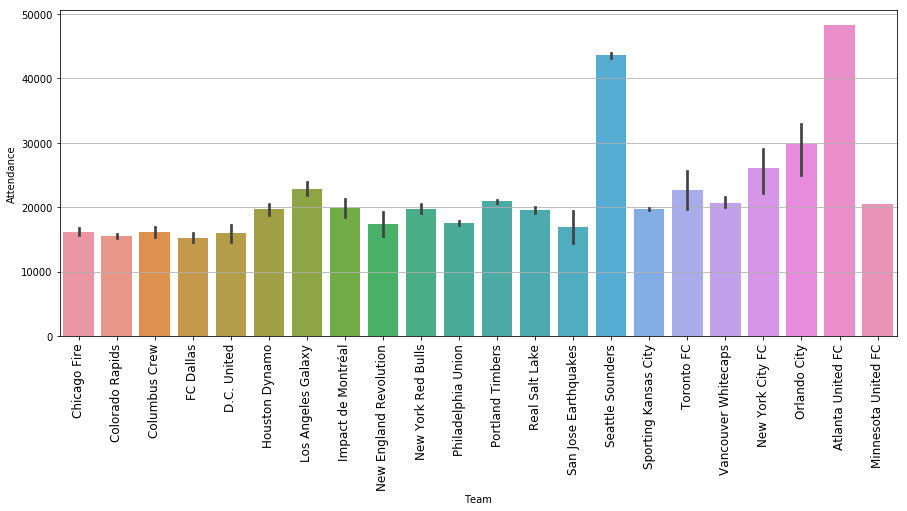

In [27]:
## plot the attendance data using seaborn library
plt.figure(figsize=(15,6))
sns.barplot(data=historical_attendence_data_1_for_chart,x="Team",y="Attendance")
plt.xticks(fontsize=12,rotation=90)
plt.grid(axis="y")

In [28]:
# import the 2011 - 2017 performance data - years in index
historical_performance_data_0= pd.read_excel("Resources/MLS_Historical_Performance.xlsx")

# add 1 year to the actual year data - since the performance of last will impact the attendace of next year
historical_performance_data_0.rename(columns={"Year":"Actual_Year"},inplace=True)
historical_performance_data_0["Year"]=historical_performance_data_0["Actual_Year"]+1
historical_performance_data_0.head()

,Pos,Team,Pld,W,L,D,Pts,Actual_Year,Year
0,1,Los Angeles Galaxy,34,19,5,10,67,2011,2012
1,2,Seattle Sounders,34,18,7,9,63,2011,2012
2,3,Real Salt Lake,34,15,11,8,53,2011,2012
3,4,FC Dallas,34,15,12,7,52,2011,2012
4,5,Sporting Kansas City,34,13,9,12,51,2011,2012


In [29]:
historical_performance_data_1=historical_performance_data_0.set_index(["Team","Year"])[['Pos','Pts']]
historical_performance_data_1.head()

,,Pos,Pts
Team,Year,,
Los Angeles Galaxy,2012,1,67
Seattle Sounders,2012,2,63
Real Salt Lake,2012,3,53
FC Dallas,2012,4,52
Sporting Kansas City,2012,5,51


In [30]:
## create dataframe with years in index
historical_performance_data = historical_performance_data_0.pivot(index="Team",columns="Actual_Year",values="Pts")
historical_performance_data.head()

Actual_Year,2011,2012,2013,2014,2015,2016,2017
Team,,,,,,,
Atlanta United FC,NaN,NaN,NaN,NaN,NaN,NaN,55.0
Chicago Fire,43.0,57.0,49.0,36.0,30.0,31.0,55.0
Chivas USA,36.0,30.0,26.0,33.0,NaN,NaN,NaN
Colorado Rapids,49.0,37.0,51.0,32.0,37.0,58.0,33.0
Columbus Crew,47.0,52.0,41.0,52.0,53.0,36.0,54.0


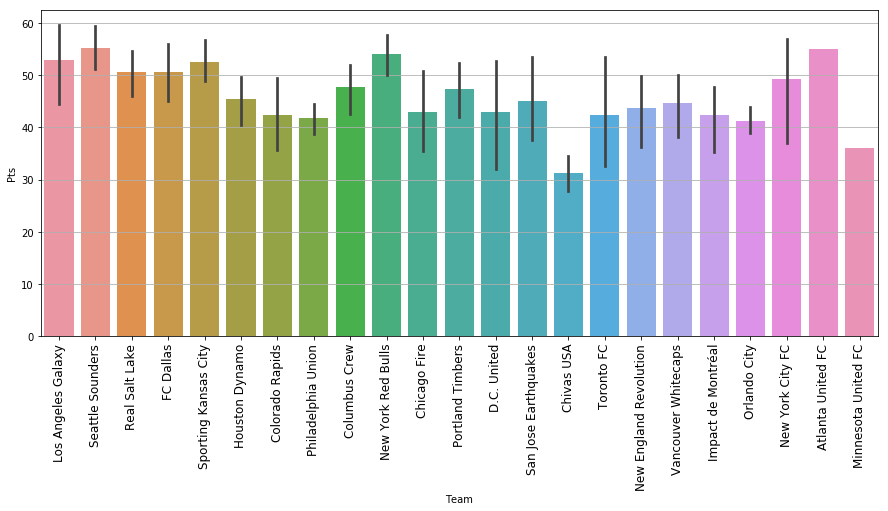

In [31]:
## plot the attendance data using seaborn library
plt.figure(figsize=(15,6))
sns.barplot(data=historical_performance_data_0,x="Team",y="Pts")
plt.xticks(fontsize=12,rotation=90)
plt.grid(axis="y")

In [32]:
# merge attendence data with performance data
merged = pd.merge(historical_attendence_data_1,historical_performance_data_1,suffixes=("_attendence", "_performance"),left_index=True,right_index=True) 
merged.head()

Attendance  Pos  Pts
Team         Year                      
Chicago Fire 2012     16409.0   11   43
             2013     15228.0    6   57
             2014     16076.0   12   49
             2015     16003.0   15   36
             2016     15602.0   20   30

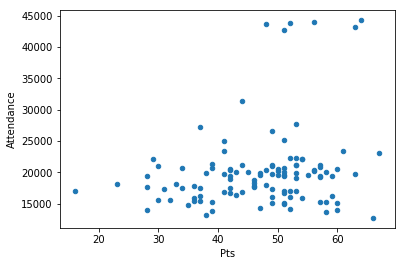

In [33]:
merged.plot(kind="scatter",y="Attendance",x="Pts")

# Final Merging & Cleanup

For the last step of cleaning, we took the previously created dataframes and converted the values into percentages to more easily represent the data during analysis. We then merged the dataframes with one another, creating one large dataframe containing all desired values, sorted by the specific teams and years. Once we finished creating the dataset, we created a small set of exploratory graphs to examine the overall results of our data collecting. This final dataset was exported for use in our final analysis.

In [34]:
# import 2012-2017 age data
age_df = pd.read_csv("Output/age_data.csv")
age_df

,Unnamed: 0,City & State,Year,Total Population,Age 18 to 29,Age 30 to 44,Team
0,0,"Atlanta city, Georgia",2012,425931,107143,101845,Atlanta United FC
1,1,"Seattle city, Washington",2012,612916,141245,157786,Seattle Sounders
2,2,"Orlando city, Florida",2012,240185,57870,56140,Orlando City
3,3,"New York city, New York",2012,8199221,1593289,1828653,New York City FC
4,4,"Carson city, California",2012,91937,16448,18000,Los Angeles Galaxy
5,5,"Newark city, New Jersey",2012,276478,56131,64131,New York Red Bulls
6,6,"Portland city, Oregon",2012,585888,113642,150432,Portland Timbers
7,7,"Minneapolis city, Minnesota",2012,385023,101775,88109,Minnesota United FC
8,8,"San Jose city, California",2012,954379,163311,224103,San Jose Earthquakes
9,9,"Kansas City city, Kansas",2012,145605,25380,28695,Sporting Kansas City


In [35]:
# Create column to hold percentile calculation for first age group and format it
age_df["Age % 18 to 29"] = age_df["Age 18 to 29"] / age_df["Total Population"] * 100
#age_df["Age % 18 to 29"] = age_df["Age % 18 to 29"].map("{:.1f}".format)

# Create column to hold percentile calculation for second age group and format it
age_df["Age % 30 to 44"] = age_df["Age 30 to 44"] / age_df["Total Population"] * 100
#age_df["Age % 30 to 44"] = age_df["Age % 30 to 44"].map("{:.1f}".format)

age_df

,Unnamed: 0,City & State,Year,Total Population,Age 18 to 29,Age 30 to 44,Team,Age % 18 to 29,Age % 30 to 44
0,0,"Atlanta city, Georgia",2012,425931,107143,101845,Atlanta United FC,25.155013,23.911150
1,1,"Seattle city, Washington",2012,612916,141245,157786,Seattle Sounders,23.044757,25.743495
2,2,"Orlando city, Florida",2012,240185,57870,56140,Orlando City,24.093928,23.373649
3,3,"New York city, New York",2012,8199221,1593289,1828653,New York City FC,19.432200,22.302765
4,4,"Carson city, California",2012,91937,16448,18000,Los Angeles Galaxy,17.890512,19.578624
5,5,"Newark city, New Jersey",2012,276478,56131,64131,New York Red Bulls,20.302158,23.195697
6,6,"Portland city, Oregon",2012,585888,113642,150432,Portland Timbers,19.396540,25.675897
7,7,"Minneapolis city, Minnesota",2012,385023,101775,88109,Minnesota United FC,26.433486,22.884087
8,8,"San Jose city, California",2012,954379,163311,224103,San Jose Earthquakes,17.111755,23.481552
9,9,"Kansas City city, Kansas",2012,145605,25380,28695,Sporting Kansas City,17.430720,19.707428


In [36]:
age_df_1=age_df.set_index(["Team","Year"])[['Age % 18 to 29', 'Age % 30 to 44']]
age_df_1.head()

,,Age % 18 to 29,Age % 30 to 44
Team,Year,,
Atlanta United FC,2012,25.155013,23.911150
Seattle Sounders,2012,23.044757,25.743495
Orlando City,2012,24.093928,23.373649
New York City FC,2012,19.432200,22.302765
Los Angeles Galaxy,2012,17.890512,19.578624


In [37]:
# import 2012-2017 ethnicity data
ethnicity_df = pd.read_csv("Output/Ethnicity_Data.csv")
ethnicity_df

,Unnamed: 0,City & State,Year,Total Population,White,Black/Afro-American,Latino,Asian,Team
0,0,"Atlanta city, Georgia",2012,425931,166054,229317,22929,14160,Atlanta United FC
1,1,"Seattle city, Washington",2012,612916,432714,47887,37880,85935,Seattle Sounders
2,2,"Orlando city, Florida",2012,240185,139251,69373,61886,7873,Orlando City
3,3,"New York city, New York",2012,8199221,3646181,2059279,2343458,1053649,New York City FC
4,4,"Carson city, California",2012,91937,29620,17968,36340,23769,Los Angeles Galaxy
5,5,"Newark city, New Jersey",2012,276478,76275,143713,91931,4508,New York Red Bulls
6,6,"Portland city, Oregon",2012,585888,454159,37922,54420,42426,Portland Timbers
7,7,"Minneapolis city, Minnesota",2012,385023,263089,67461,38156,21153,Minnesota United FC
8,8,"San Jose city, California",2012,954379,448526,29674,315241,310783,San Jose Earthquakes
9,9,"Kansas City city, Kansas",2012,145605,86500,39568,40187,4067,Sporting Kansas City


In [38]:
# Create percentage calculations for ethnicity
ethnicity_df["White Percentage"] = ethnicity_df["White"] / ethnicity_df["Total Population"] * 100
ethnicity_df["Black Percentage"] = ethnicity_df["Black/Afro-American"] / ethnicity_df["Total Population"] * 100
ethnicity_df["Latino Percentage"] = ethnicity_df["Latino"] / ethnicity_df["Total Population"] * 100
ethnicity_df["Asian Percentage"] = ethnicity_df["Asian"] / ethnicity_df["Total Population"] * 100

# Format new columns
#ethnicity_df["White Percentage"] = ethnicity_df["White Percentage"].map("{:.1f}".format)
#ethnicity_df["Black Percentage"] = ethnicity_df["Black Percentage"].map("{:.1f}".format)
#ethnicity_df["Latino Percentage"] = ethnicity_df["Latino Percentage"].map("{:.1f}".format)
#ethnicity_df["Asian Percentage"] = ethnicity_df["Asian Percentage"].map("{:.1f}".format)

ethnicity_df

,Unnamed: 0,City & State,Year,Total Population,White,Black/Afro-American,Latino,Asian,Team,White Percentage,Black Percentage,Latino Percentage,Asian Percentage
0,0,"Atlanta city, Georgia",2012,425931,166054,229317,22929,14160,Atlanta United FC,38.986127,53.839002,5.383266,3.324482
1,1,"Seattle city, Washington",2012,612916,432714,47887,37880,85935,Seattle Sounders,70.599234,7.812979,6.180292,14.020681
2,2,"Orlando city, Florida",2012,240185,139251,69373,61886,7873,Orlando City,57.976560,28.883153,25.765972,3.277890
3,3,"New York city, New York",2012,8199221,3646181,2059279,2343458,1053649,New York City FC,44.469847,25.115545,28.581471,12.850599
4,4,"Carson city, California",2012,91937,29620,17968,36340,23769,Los Angeles Galaxy,32.217714,19.543818,39.527067,25.853574
5,5,"Newark city, New Jersey",2012,276478,76275,143713,91931,4508,New York Red Bulls,27.588090,51.979904,33.250747,1.630509
6,6,"Portland city, Oregon",2012,585888,454159,37922,54420,42426,Portland Timbers,77.516351,6.472568,9.288465,7.241316
7,7,"Minneapolis city, Minnesota",2012,385023,263089,67461,38156,21153,Minnesota United FC,68.330723,17.521291,9.910057,5.493958
8,8,"San Jose city, California",2012,954379,448526,29674,315241,310783,San Jose Earthquakes,46.996633,3.109247,33.031008,32.563898
9,9,"Kansas City city, Kansas",2012,145605,86500,39568,40187,4067,Sporting Kansas City,59.407301,27.174891,27.600014,2.793173


In [39]:
ethnicity_df_1=ethnicity_df.set_index(["Team","Year"])[['White Percentage',
       'Black Percentage', 'Latino Percentage', 'Asian Percentage']]

ethnicity_df_1.head()

,,White Percentage,Black Percentage,Latino Percentage,Asian Percentage
Team,Year,,,,
Atlanta United FC,2012,38.986127,53.839002,5.383266,3.324482
Seattle Sounders,2012,70.599234,7.812979,6.180292,14.020681
Orlando City,2012,57.976560,28.883153,25.765972,3.277890
New York City FC,2012,44.469847,25.115545,28.581471,12.850599
Los Angeles Galaxy,2012,32.217714,19.543818,39.527067,25.853574


In [40]:
# import 2012-2017 income data
income_df = pd.read_csv("Output/Income_Data.csv")
income_df

,Unnamed: 0,City & State,Year,Total Households,Less Than 10k,10k to 19k,20k to 34k,35k to 49k,50k to 74k,75k to 99k,100k or More,Team
0,0,"Atlanta city, Georgia",2012,82411,3927,5767,8848,8415,12978,9297,33179,Atlanta United FC
1,1,"Seattle city, Washington",2012,135156,3116,4740,9032,10904,21507,19591,66266,Seattle Sounders
2,2,"Orlando city, Florida",2012,39155,1592,3130,5172,5452,8160,4956,10693,Orlando City
3,3,"New York city, New York",2012,990609,32020,55634,99465,94989,159436,137947,411118,New York City FC
4,4,"Carson city, California",2012,18831,436,975,1756,1990,3318,3627,6729,Los Angeles Galaxy
5,5,"Newark city, New Jersey",2012,21652,851,1690,2796,2643,4780,3071,5821,New York Red Bulls
6,6,"Portland city, Oregon",2012,133777,3948,7286,13251,15980,26782,20941,45589,Portland Timbers
7,7,"Minneapolis city, Minnesota",2012,83163,2419,4179,8173,9708,16267,13284,29133,Minnesota United FC
8,8,"San Jose city, California",2012,178328,3451,5992,10920,13542,24284,23536,96603,San Jose Earthquakes
9,9,"Kansas City city, Kansas",2012,32123,1880,2936,5906,5109,7287,4232,4773,Sporting Kansas City


In [41]:
# Create percentage calculations for income
income_df["less than 34k"] = income_df["Less Than 10k"] +income_df["10k to 19k"] +income_df["20k to 34k"] 
income_df["less than 34k Percentage"] = income_df["less than 34k"]/ income_df["Total Households"] * 100

income_df["34k to 99k"] = income_df["35k to 49k"] +income_df["50k to 74k"] +income_df["75k to 99k"]
income_df["34k to 99k Percentage"] = income_df["34k to 99k"]/ income_df["Total Households"] * 100

#income_df["100k or more"] = income_df["100k or more"] 
income_df["100k or more Percentage"] = income_df["100k or More"] / income_df["Total Households"] * 100

In [42]:
income_df_1 = income_df.set_index(["Team","Year"])[['less than 34k Percentage','34k to 99k Percentage', '100k or more Percentage']]
income_df_1

,,less than 34k Percentage,34k to 99k Percentage,100k or more Percentage
Team,Year,,,
Atlanta United FC,2012,22.499424,37.240174,40.260402
Seattle Sounders,2012,12.495191,38.475539,49.029270
Orlando City,2012,25.268803,47.421785,27.309411
New York City FC,2012,18.889289,39.609170,41.501541
Los Angeles Galaxy,2012,16.818013,47.448356,35.733631
New York Red Bulls,2012,24.648993,48.466654,26.884352
Portland Timbers,2012,18.302847,47.618798,34.078354
Minnesota United FC,2012,17.761505,47.207292,35.031204
San Jose Earthquakes,2012,11.418846,34.409627,54.171527


In [43]:
# merge demographic data into dataframe -1. age
merged2 = pd.merge(merged,age_df_1,left_index=True,right_index=True) 
merged2.head()

Attendance  Pos  Pts  Age % 18 to 29  Age % 30 to 44
Team         Year                                                      
Chicago Fire 2012     16409.0   11   43       15.767964       18.152983
             2013     15228.0    6   57       15.950659       17.457617
             2014     16076.0   12   49       13.818731       18.833837
             2015     16003.0   15   36       13.863928       19.157650
             2016     15602.0   20   30       13.888041       20.188023

In [44]:
# merge demographic data into dataframe -2 ethnicity
merged3 = pd.merge(merged2,ethnicity_df_1,left_index=True,right_index=True) 
merged3.head()

Attendance  Pos  Pts  Age % 18 to 29  Age % 30 to 44  \
Team         Year                                                         
Chicago Fire 2012     16409.0   11   43       15.767964       18.152983   
             2013     15228.0    6   57       15.950659       17.457617   
             2014     16076.0   12   49       13.818731       18.833837   
             2015     16003.0   15   36       13.863928       19.157650   
             2016     15602.0   20   30       13.888041       20.188023   

                   White Percentage  Black Percentage  Latino Percentage  \
Team         Year                                                          
Chicago Fire 2012         84.225936          3.159693          16.823228   
             2013         85.045877          2.910616          16.959349   
             2014         86.368580          2.247734          17.093656   
             2015         86.478391          2.121157          16.730852   
             2016         85.837250          3.949698          16.989195   

                   Asian Percentage  
Team         Year                    
Chicago Fire 2012          6.416982  
             2013          5.462721  
             2014          4.549849  
             2015          4.517391  
             2016          5.182834

In [45]:
# merge demographic data into dataframe -3 income
merged_final = pd.merge(merged3,income_df_1,left_index=True,right_index=True)

merged_final.to_csv("Output/final_all_data.csv")

merged_final

Attendance  Pos  Pts  Age % 18 to 29  \
Team                 Year                                         
Chicago Fire         2012     16409.0   11   43       15.767964   
                     2013     15228.0    6   57       15.950659   
                     2014     16076.0   12   49       13.818731   
                     2015     16003.0   15   36       13.863928   
                     2016     15602.0   20   30       13.888041   
                     2017     17383.0   20   31       13.888041   
Colorado Rapids      2012     15175.0    7   49       17.041087   
                     2013     15440.0   14   37       15.267046   
                     2014     15082.0    8   51       14.717577   
                     2015     15657.0   17   32       14.281174   
                     2016     16278.0   19   37       14.237111   
                     2017     15322.0    2   58       14.237111   
Columbus Crew        2012     14397.0    9   47       23.960727   
                     2013     16080.0   10   52       23.642570   
                     2014     16881.0   16   41       23.500664   
                     2015     16985.0    7   52       23.517000   
                     2016     17125.0    4   53       23.406942   
                     2017     15439.0   18   36       23.406942   
D.C. United          2012     13846.0   13   39       25.351501   
                     2013     13646.0    3   58       25.245451   
                     2014     17030.0   19   16       25.024932   
                     2015     16244.0    3   59       24.623774   
                     2016     17081.0    8   51       24.195572   
                     2017     17904.0   10   46       24.195572   
FC Dallas            2012     14199.0    4   52       10.335716   
                     2013     15373.0   13   39       10.226988   
                     2014     16816.0   15   44        9.990115   
                     2015     16015.0    6   54       10.090931   
                     2016     14094.0    2   60        9.260124   
                     2017     15122.0    1   60        9.260124   
...                               ...  ...  ...             ...   
Portland Timbers     2012     20438.0   12   42       19.396540   
                     2013     20674.0   17   34       19.007142   
                     2014     20806.0    3   57       18.719547   
                     2015     21144.0   11   49       18.416677   
                     2016     21144.0    5   53       18.197712   
                     2017     21144.0   12   44       18.197712   
Real Salt Lake       2012     19087.0    3   53       15.561897   
                     2013     19218.0    5   57       15.866339   
                     2014     20351.0    4   56       15.666715   
                     2015     20160.0    4   56       15.469831   
                     2016     19759.0   16   41       15.294017   
                     2017     18781.0    9   46       15.294017   
San Jose Earthquakes 2012     13293.0   14   38       17.111755   
                     2013     12765.0    1   66       17.068169   
                     2014     14947.0   10   51       16.920269   
                     2015     20979.0   18   30       16.852407   
                     2016     19930.0   13   47       16.949502   
                     2017     19875.0   17   38       16.949502   
Seattle Sounders     2012     43144.0    2   63       23.044757   
                     2013     44038.0    7   56       22.800918   
                     2014     43734.0    6   52       22.767579   
                     2015     44247.0    1   64       22.874902   
                     2016     42636.0    6   51       22.956751   
                     2017     43666.0    7   48       22.956751   
Sporting Kansas City 2012     19404.0    5   51       17.430720   
                     2013     19708.0    2   63       17.225288   
                     2014     20003.0    2   58       17.066627   
       

In [46]:
merged_final.columns

Index(['Attendance', 'Pos', 'Pts', 'Age % 18 to 29', 'Age % 30 to 44',
       'White Percentage', 'Black Percentage', 'Latino Percentage',
       'Asian Percentage', 'less than 34k Percentage', '34k to 99k Percentage',
       '100k or more Percentage'],
      dtype='object')

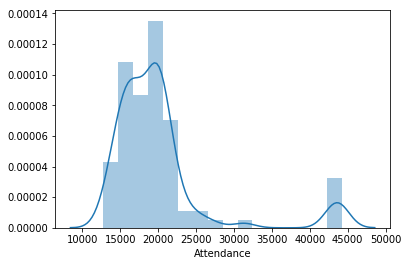

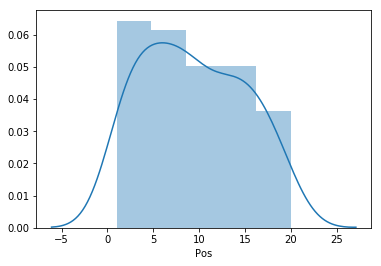

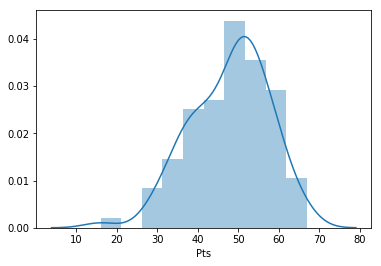

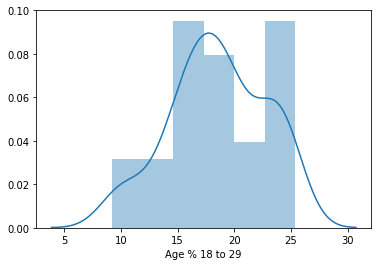

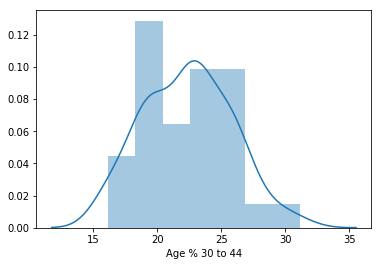

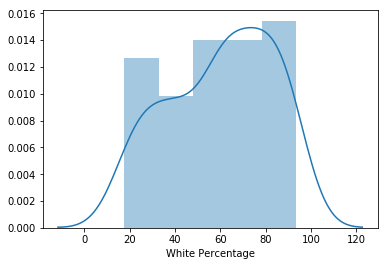

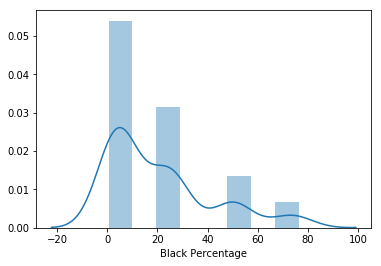

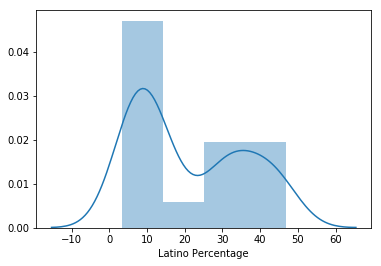

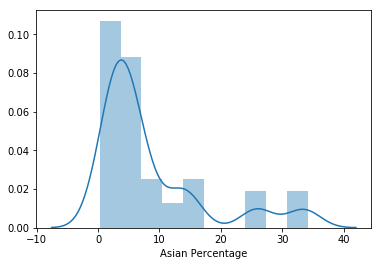

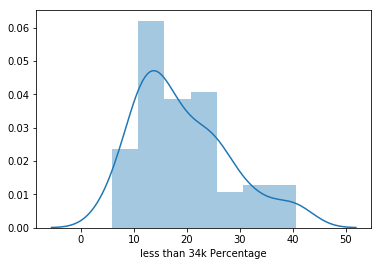

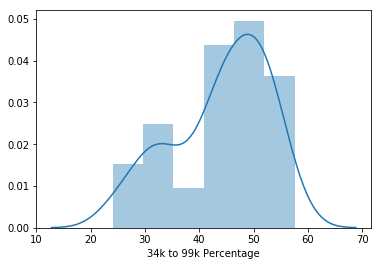

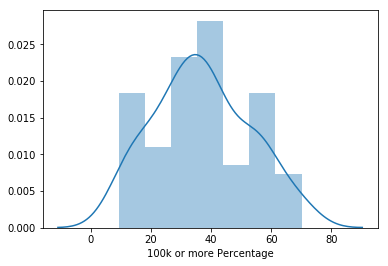

In [47]:
for vars in merged_final.columns:
    sns.distplot(merged_final[vars])
    plt.show()